In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from urllib.parse import urlparse
from collections import Counter
from rapidfuzz import fuzz # type: ignore
import re
import math
try:
    import Levenshtein # type: ignore
    def levenshtein_distance(a: str, b: str) -> int:
        return Levenshtein.distance(a, b)
except Exception:
    # Fallback: simple DP implementation
    def levenshtein_distance(a: str, b: str) -> int:
        n, m = len(a), len(b)
        if n == 0:
            return m
        if m == 0:
            return n
        dp = [[0] * (m + 1) for _ in range(n + 1)]
        for i in range(n + 1):
            dp[i][0] = i
        for j in range(m + 1):
            dp[0][j] = j
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = 0 if a[i - 1] == b[j - 1] else 1
                dp[i][j] = min(
                    dp[i - 1][j] + 1,      # deletion
                    dp[i][j - 1] + 1,      # insertion
                    dp[i - 1][j - 1] + cost # substitution
                )
        return dp[n][m]


In [2]:
# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv("../data/phishing_site_urls.csv")

# Clean missing or null
df = df.dropna()

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['Label'].value_counts()}")

Dataset shape: (549346, 2)
Label distribution:
Label
good    392924
bad     156422
Name: count, dtype: int64


In [3]:
# ===============================
# 2. Feature Extraction Function
# ===============================

BASE_DIR = Path.cwd()
ASSETS_DIR = BASE_DIR.parent.parent / "api"

# Load all domains from file
with open(ASSETS_DIR / "top_domains.txt", "r") as f:
    all_domains = [line.strip().lower() for line in f if line.strip()]

# Choose top N domains for similarity
N = 100  # change to 100 / 500 / 1000 as needed (max=1000)
TOP_DOMAINS = all_domains[:N]

print(f"Using top {N} domains for similarity, total:", len(TOP_DOMAINS))

# Suspicious TLDs often seen in phishing
SUSPICIOUS_TLDS = {".tk", ".ml", ".ga", ".cf", ".gq", ".xyz", ".club", ".top", ".work"}

PHISHING_KEYWORDS = [
    "login", "signin", "verify", "account", "secure", "update", "confirm",
    "webscr", "ebayisapi", "banking", "service", "payment", "paypal",
    "security", "billing", "credential", "support", "unlock", "submit",
    "validate", "recovery", "purchase", "checkout", "order", "wallet",
    "transfer", "invoice", "bonus", "free", "reward", "alert", "notification",
    "official", "customer", "safe", "portal", "authenticate", "session",
    "id", "password", "user", "signinpage", "phishing", "fraud", "malware",
    "scam", "hack", "suspicious"
]

# -----------------------
# Helper Functions
# -----------------------

def shannon_entropy(text: str) -> float:
    if not text:
        return 0.0
    counts = Counter(text)
    length = len(text)
    entropy = 0.0
    for c in counts.values():
        p = c / length
        entropy -= p * math.log2(p)
    return float(entropy)

def longest_digit_run(text: str) -> int:
    max_run = 0
    current = 0
    for ch in text:
        if ch.isdigit():
            current += 1
            if current > max_run:
                max_run = current
        else:
            current = 0
    return max_run

def domain_from_url(url: str) -> str:
    try:
        parsed = urlparse(url if "://" in url else "https://" + url)
        host = parsed.netloc.split(":")[0]
        return host.lower()
    except Exception:
        return url.lower()

# -----------------------
# Main Feature Extraction
# -----------------------

def extract_features(url: str) -> dict:
    # -----------------------
    # Parse URL
    # -----------------------
    try:
        parsed = urlparse(url)
        hostname = parsed.netloc or parsed.path.split("/")[0]
        scheme = parsed.scheme
    except:
        parsed = urlparse("http://" + url)
        hostname = parsed.netloc
        scheme = parsed.scheme

    domain = hostname.replace("www.", "").split(":")[0]
    tld = "." + domain.split(".")[-1] if "." in domain else ""

    # -----------------------
    # Base Features
    # -----------------------
    features = {
        "url_length": len(url),
        "num_digits": sum(c.isdigit() for c in url),
        "num_special": len(re.findall(r"[^a-zA-Z0-9]", url)),
        "has_https": int(scheme.lower() == "https"),
        "num_dots": url.count("."),
        "has_at": int("@" in url),
        "has_ip": int(bool(re.search(r"\b\d{1,3}(\.\d{1,3}){3}\b", hostname))),
        "url_depth": max(url.count("/") - 2, 0),
        "has_keywords": int(any(keyword in url.lower() for keyword in PHISHING_KEYWORDS)),
        "hostname_length": len(hostname),
        "is_top_domain": int(any(top in hostname for top in TOP_DOMAINS)),
        "suspicious_tld": int(tld.lower() in SUSPICIOUS_TLDS),
    }

    # -----------------------
    # Advanced Features
    # -----------------------
    features["url_entropy"] = shannon_entropy(url)
    features["hyphen_count"] = url.count("-")
    features["longest_digit_seq"] = longest_digit_run(url)

    # Levenshtein / similarity against top domains using RapidFuzz
    if TOP_DOMAINS:
        similarities = [fuzz.ratio(domain, td) / 100.0 for td in TOP_DOMAINS]
        features["levenshtein_sim_top"] = max(similarities)
    else:
        features["levenshtein_sim_top"] = 0.0

    return features

Using top 100 domains for similarity, total: 100


In [4]:
# ===============================
# 3. Feature Engineering
# ===============================
print("Extracting features...")
features = df["URL"].apply(lambda url: extract_features(url))
X = pd.DataFrame(features.tolist())

# Ensure column order
expected_features = [
    "url_length",
    "num_digits",
    "num_special",
    "has_https",
    "num_dots",
    "has_at",
    "has_ip",
    "url_depth",
    "has_keywords",
    "hostname_length",
    "is_top_domain",
    "suspicious_tld",
    "url_entropy",
    "hyphen_count",
    "longest_digit_seq",
    "levenshtein_sim_top",
]
X = X[expected_features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Label"])

# Diagnostics
print(f"Label shape: {y.shape}")
print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print(f"Bad labels: {(y == 1).sum()}")
print(f"Good labels: {(y == 0).sum()}")
print(f"Feature matrix shape: {X.shape}")
print(f"Feature columns: {X.columns.tolist()}")

print("\nFeature DataFrame head:")
print(X.head())

Extracting features...
Label shape: (549346,)
Label mapping: {'bad': 0, 'good': 1}
Bad labels: 392924
Good labels: 156422
Feature matrix shape: (549346, 16)
Feature columns: ['url_length', 'num_digits', 'num_special', 'has_https', 'num_dots', 'has_at', 'has_ip', 'url_depth', 'has_keywords', 'hostname_length', 'is_top_domain', 'suspicious_tld', 'url_entropy', 'hyphen_count', 'longest_digit_seq', 'levenshtein_sim_top']

Feature DataFrame head:
   url_length  num_digits  num_special  has_https  num_dots  has_at  has_ip  \
0         225          58           32          0         6       0       0   
1          81           1           15          0         5       0       0   
2         177          47           19          0         7       0       0   
3          60           0            8          0         6       0       0   
4         116          21           13          0         1       0       0   

   url_depth  has_keywords  hostname_length  is_top_domain  suspicious_tld  \
0

In [5]:
# ===============================
# 4. Train/Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(X_train[:10])
print(y_train[:10])

Training set size: 439476
Test set size: 109870
        url_length  num_digits  num_special  has_https  num_dots  has_at  \
6568            47           0            7          0         3       0   
253378          51           8            9          0         1       0   
125197          51          19            4          0         1       0   
279167          15           0            2          0         1       0   
113677          45           0            6          0         2       0   
169221          45           0            5          0         2       0   
392366          49           0            6          0         2       0   
286105         103           5           16          0         2       0   
247135          96          11           16          0         1       0   
233345          15           0            2          0         1       0   

        has_ip  url_depth  has_keywords  hostname_length  is_top_domain  \
6568         0          1             1 

In [6]:
# ===============================
# 5. Train Model
# ===============================

# Count classes in training set
counts = np.bincount(y_train)
neg, pos = counts[0], counts[1]

clf = XGBClassifier(
    scale_pos_weight=neg / pos,
    use_label_encoder=False
)

# clf_RandomForest = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42
# )

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# clf_RandomForest.fit(
#     X_train, y_train,
# )

[0]	validation_0-logloss:0.59450
[1]	validation_0-logloss:0.54161
[2]	validation_0-logloss:0.49815


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:53:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[3]	validation_0-logloss:0.46715
[4]	validation_0-logloss:0.44643
[5]	validation_0-logloss:0.42647
[6]	validation_0-logloss:0.41399
[7]	validation_0-logloss:0.40607
[8]	validation_0-logloss:0.39562
[9]	validation_0-logloss:0.38753
[10]	validation_0-logloss:0.38176
[11]	validation_0-logloss:0.37739
[12]	validation_0-logloss:0.37399
[13]	validation_0-logloss:0.37143
[14]	validation_0-logloss:0.36493
[15]	validation_0-logloss:0.36164
[16]	validation_0-logloss:0.35710
[17]	validation_0-logloss:0.35614
[18]	validation_0-logloss:0.35413
[19]	validation_0-logloss:0.35138
[20]	validation_0-logloss:0.34537
[21]	validation_0-logloss:0.34453
[22]	validation_0-logloss:0.34346
[23]	validation_0-logloss:0.33942
[24]	validation_0-logloss:0.33697
[25]	validation_0-logloss:0.33645
[26]	validation_0-logloss:0.33469
[27]	validation_0-logloss:0.33363
[28]	validation_0-logloss:0.33250
[29]	validation_0-logloss:0.32981
[30]	validation_0-logloss:0.32749
[31]	validation_0-logloss:0.32668
[32]	validation_0-log

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
# ===============================
# 6. Evaluate
# ===============================
#XGB
target_names = label_encoder.classes_
y_pred = clf.predict(X_test)
print("\nClassification Report XGB:")
print(classification_report(y_test, y_pred, target_names=target_names))
# #RF
# target_names = label_encoder.classes_
# y_pred = clf_RandomForest.predict(X_test)
# print("\nClassification Report RF:")
# print(classification_report(y_test, y_pred, target_names=target_names))
# #SVM
# target_names = label_encoder.classes_
# y_pred = clf_SVM.predict(X_test)
# print("\nClassification Report SVM:")
# print(classification_report(y_test, y_pred, 


Classification Report XGB:
              precision    recall  f1-score   support

         bad       0.75      0.85      0.80     31285
        good       0.94      0.89      0.91     78585

    accuracy                           0.88    109870
   macro avg       0.84      0.87      0.85    109870
weighted avg       0.88      0.88      0.88    109870



In [8]:
# Feature importance
feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": clf.feature_importances_}
).sort_values("importance", ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                feature  importance
11       suspicious_tld    0.126297
8          has_keywords    0.117390
1            num_digits    0.111725
15  levenshtein_sim_top    0.096743
4              num_dots    0.082689
7             url_depth    0.080076
14    longest_digit_seq    0.075179
13         hyphen_count    0.061857
5                has_at    0.058513
10        is_top_domain    0.058083
2           num_special    0.054349
0            url_length    0.028160
9       hostname_length    0.023950
12          url_entropy    0.022213
6                has_ip    0.002776
3             has_https    0.000000


In [9]:
# ===============================
# 8. Test Model with Real URLs
# ===============================
print("\nTesting model with real URLs...")

# Test URLs with known characteristics
test_urls = [
    "https://google.com",  # good
    "https://paypal-secure-verify.com",  # bad
    "https://bank-update-account.net",  # bad
    "https://bit.ly/suspicious-link",  # bad
    "https://www.amazon.com",  # good
    "https://secure-login-verify-account.com",  # bad
    "https://example.com",  # good
    "https://phishing-site.com",  # bad
    "https://another-phishing-site.com",  # bad
    "https://legitimate-site.com",  # good
    "https://suspicious-site.com",  # bad
    "https://update-paypal-security.com",  # bad
    "https://microsoft.com",  # good
    "https://login-microsoft-verify.com",  # bad
    "https://secure-dropbox-login.com",  # bad
    "https://dropbox.com",  # good
    "https://www.facebook.com",  # good
    "https://facebook-support-login.com",  # bad
    "https://appleid.apple.com",  # good
    "https://apple-support-verify-login.com",  # bad
    "https://ebay.com",  # good
    "https://ebay-account-update.com",  # bad
    "https://cnn.com",  # good
    "https://news-cnn-alert.com",  # bad
    "https://github.com",  # good
    "https://github-verify-login.com",  # bad
    "https://instagram.com",  # good
    "https://insta-verify-login.com",  # bad
    "https://weather.com",  # good
    "https://weather-alert-verify.com",  # bad
]

expected_labels = [
    "good", "bad", "bad", "bad", "good",
    "bad", "good", "bad", "bad", "good",
    "bad", "bad", "good", "bad", "bad",
    "good", "good", "bad", "good", "bad",
    "good", "bad", "good", "bad", "good",
    "bad", "good", "bad", "good", "bad"
]

for i, (url, expected) in enumerate(zip(test_urls, expected_labels)):
    features = extract_features(url)
    features_df = pd.DataFrame([features])[expected_features]
    prediction = clf.predict(features_df)[0]
    predicted_label = label_encoder.inverse_transform([prediction])[0]

    status = "✅" if predicted_label == expected else "❌"
    print(f"{status} URL: {url}")
    print(f"   Expected: {expected}, Predicted: {predicted_label}")
    print(f"   Features: {features}")
    print()

# Overall test accuracy
test_features = [extract_features(url) for url in test_urls]
test_X = pd.DataFrame(test_features)[expected_features]
test_y = label_encoder.transform(expected_labels)
test_y_pred = clf.predict(test_X)
test_accuracy = accuracy_score(test_y, test_y_pred)
print(f"Test accuracy on sample URLs: {test_accuracy*100:.2f}%")


Testing model with real URLs...
✅ URL: https://google.com
   Expected: good, Predicted: good
   Features: {'url_length': 18, 'num_digits': 0, 'num_special': 4, 'has_https': 1, 'num_dots': 1, 'has_at': 0, 'has_ip': 0, 'url_depth': 0, 'has_keywords': 0, 'hostname_length': 10, 'is_top_domain': 1, 'suspicious_tld': 0, 'url_entropy': 3.5724312513221195, 'hyphen_count': 0, 'longest_digit_seq': 0, 'levenshtein_sim_top': 1.0}

✅ URL: https://paypal-secure-verify.com
   Expected: bad, Predicted: bad
   Features: {'url_length': 32, 'num_digits': 0, 'num_special': 6, 'has_https': 1, 'num_dots': 1, 'has_at': 0, 'has_ip': 0, 'url_depth': 0, 'has_keywords': 1, 'hostname_length': 24, 'is_top_domain': 0, 'suspicious_tld': 0, 'url_entropy': 4.202819531114783, 'hyphen_count': 2, 'longest_digit_seq': 0, 'levenshtein_sim_top': 0.48484848484848486}

✅ URL: https://bank-update-account.net
   Expected: bad, Predicted: bad
   Features: {'url_length': 31, 'num_digits': 0, 'num_special': 6, 'has_https': 1, 'nu

In [10]:
from sklearn.metrics import precision_recall_curve

y_proba = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=0)
print("Precision:\n",precision,"\nRecall:\n", recall,"\nThresholds:\n", thresholds)


Precision:
 [0.28474561 0.2847391  0.28473259 ... 0.         0.         1.        ] 
Recall:
 [1.         0.99996804 0.99993607 ... 0.         0.         0.        ] 
Thresholds:
 [1.1007857e-06 2.2988856e-06 2.7916083e-06 ... 9.9998403e-01 9.9998498e-01
 9.9998748e-01]


In [11]:
import numpy as np
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 31285, 1: 78585}


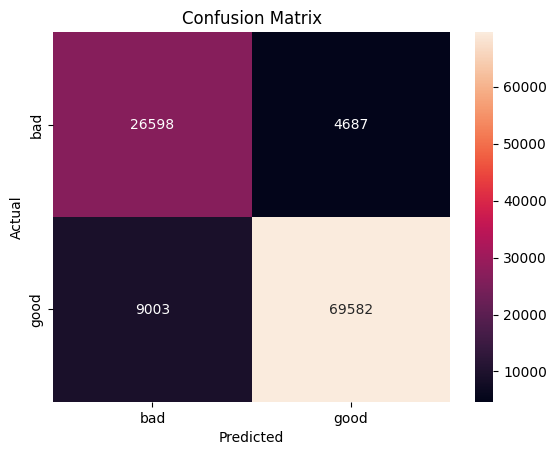

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


{0: 31285, 1: 78585}


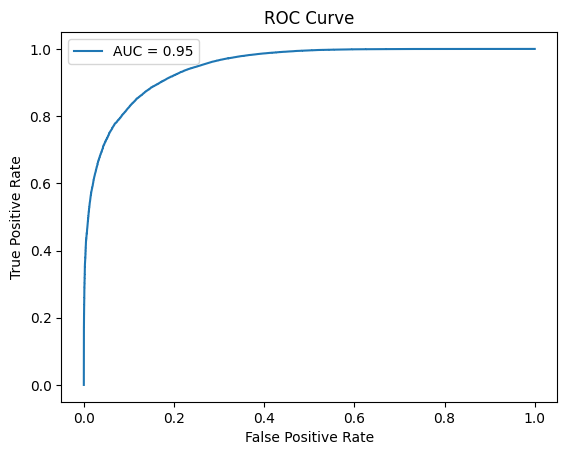

In [13]:
from sklearn.metrics import roc_curve, auc

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# ===============================
# 7. Save Model and Encoder
# ===============================
joblib.dump(clf, 'model_XGBClassifier.pkl')
joblib.dump(label_encoder, 'label_encoder_XGBClassifier.pkl')

print("\n✅ Model and label encoder saved.")


✅ Model and label encoder saved.


: 

In [ ]:
import joblib
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType


In [ ]:
import joblib
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

# Load trained model
model = joblib.load("model_XGBClassifier.pkl")

# Fix feature names to numeric f0, f1, ...
model.get_booster().feature_names = [f"f{i}" for i in range(model.n_features_in_)]

# Prepare input type
n_features = model.n_features_in_
initial_type = [('input', FloatTensorType([None, n_features]))]

# Convert to ONNX
onnx_model = onnxmltools.convert_xgboost(
    model,
    initial_types=initial_type,
    target_opset=15  # <- use supported opset
)

# Save ONNX
with open("model_XGBClassifier.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
